# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.


### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [78]:
import pandas as pd
import numpy as np
from scipy import stats

In [79]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [80]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [81]:
data.head()

****
****

## Solution by Jonas Cuadrado

July 18, 2018

### 1. Test and CLT

We want to determine if the call back rate for white and black people is the same. This is equivalent to determining if two coins have the same head-tails probabilities, given a run of flips for each. Therefore, we need to perform a 2-sample t-test.

CLT does not apply to the individual probabilities, as we are dealing with discrete distributions. **However**, it does apply to the difference in call-back rate, since it is a continuous variable and we have over 30 samples.


### 2. H_0 and H_A

We will take the null hypothesis as: "There is the same call back rate for the two groups", and the alternative as "Black people are called back LESS than white people (therefore, they are discriminated)"

### 3. Evaluation of the data

Let's have a look at the data first in a general sense

In [89]:
ambos = data[['race','call']]
w = ambos[ambos.race=='w']
b = ambos[ambos.race=='b']

cbrW = w.call.sum()/w.call.count()
cbrB = b.call.sum()/b.call.count()

print('MEAN Call back rate = ', ambos.call.sum()/ambos.call.count())
print('WHITE Call back rate = ', cbrW)
print('BLACK Call back rate = ', cbrB)
print('Difference = ', abs(cbrW-cbrB))

MEAN Call back rate =  0.08049281314168377
WHITE Call back rate =  0.09650924024640657
BLACK Call back rate =  0.06447638603696099
Difference =  0.032032854209445585


The difference in call back rates is 3%, or about half of the call back rate seen by black applicants.

This value may be statistically significant. first, we can use the frequentist approach:

In [83]:
# FREQUENSTIST/ANALYTICAL
var_w = cbrW*(1-cbrW)/w.call.count()
var_b = cbrB*(1-cbrB)/b.call.count()

std_bw = np.sqrt(var_w+var_b)

marginoferr = 1.96*std_bw
print('Margin of error of the difference = ', marginoferr)

print('Confidence interval: ', [abs(cbrW-cbrB)-marginoferr,abs(cbrW-cbrB)+marginoferr] )

print('p-value:', stats.ttest_ind(b.call,w.call,equal_var=False).pvalue)

Margin of error of the difference =  0.015255406349886438
Confidence interval:  [0.016777447859559147, 0.047288260559332024]
p-value: 3.942941513645935e-05


Indeed, the p-value in less than 1%, so we should be able to reject the null hypothesis. Let's confirm this by running a bootstrap analysis of the data.

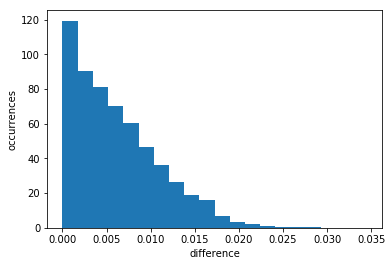

Bootstrapped p-value:  8e-05


In [84]:
# BOOTSTRAPPING
import matplotlib.pyplot as plt

pdb = b.call.values
pdw = w.call.values
cbmerged = np.concatenate((pdb,pdw))

numofbs = 25000
bsdiffs = np.empty(numofbs)
for i in range(numofbs):
    bssample = np.random.permutation(cbmerged)
    meancb1 = np.mean(bssample[:len(pdb)])
    meancb2 = np.mean(bssample[len(pdb):])
    bsdiffs[i] = abs(meancb2-meancb1)

plt.hist(bsdiffs, bins=20, normed=True)
plt.xlabel('difference')
plt.ylabel('occurrences')
plt.show()

# to dins the p-value we need to find the occurrences above our
print('Bootstrapped p-value: ', np.sum(bsdiffs>=abs(cbrW-cbrB))/numofbs)

In both cases, the p-value is smaller than 1%, so there is enough significance to reject the null hypothesis: there is indeed discrimination. The values reported differ by a factor of 2, but that's because the bootstrap results find 2 occurrence in 25000. One can increase the iterations to obtain a more accurate result, although it is not necessary.

## Pre-5. Most important factors

To see if there is a parameter that influences th call-back rate more than race, let's explore the correlation between 'call' and the other variables. However, we need to convert 'race' to a numerical value first.

In [85]:
data2 = data.copy()
data2['race'] = data2['race'].map({'w': 1, 'b': 0})

# I can look at the correlation matrix...
print(data2.corr().loc['call'].sort_values(ascending=False).head(10))

call             1.000000
specialskills    0.111074
honors           0.071951
empholes         0.071888
adid             0.063178
yearsexp         0.061436
race             0.058872
linc             0.049649
offsupport       0.047783
lmedhhinc        0.047699
Name: call, dtype: float64


We observe that 'special skills' has the highest degree of correlation with call-backs, followed by 'honors'. Education does not even appear here. When we look at the rates in a pivot table, we see a larger difference between the call-back rates on those variables than on race, usually a factor of 2. However, as expected, the education label does not see such variability. This allos us to confirm that race is important, but not the most important factor in call-back rates

In [88]:
pt_specialskills = pd.pivot_table(data,values=['call'],index=['specialskills'],columns=['race'],aggfunc=np.mean)
print('\nCall back rate comparison: specialskills vs race\n')
print(pt_specialskills)

pt_honors = pd.pivot_table(data,values=['call'],index=['honors'],columns=['race'],aggfunc=np.mean)
print('\nCall back rate comparison: honors vs race\n')
print(pt_honors)

pt_education = pd.pivot_table(data,values=['call'],index=['education'],columns=['race'],aggfunc=np.mean)
print('\nCall back rate comparison: education vs race\n')
print(pt_education)




Call back rate comparison: specialskills vs race

                   call          
race                  b         w
specialskills                    
0              0.047619  0.071122
1              0.099122  0.148010

Call back rate comparison: honors vs race

            call          
race           b         w
honors                    
0       0.061039  0.090751
1       0.128000  0.196970

Call back rate comparison: education vs race

               call          
race              b         w
education                    
0          0.107143  0.000000
1          0.090909  0.055556
2          0.068182  0.112676
3          0.058824  0.107212
4          0.064773  0.093463


### 4 and 5. Report

The data shows evidence that race plays an important role in the call-back rate of job applications. In particular, applicants labelled as black receive on average about 33% less call backs than whites. This value is statistically significant since the probability of randomly finding a similar response is less than 1 in 25000. In other words, there is over 99% confidence that black applicants are discriminated against.

However, this does not mean that race is the most important factor in callback success. In fact, applicants with special skills for the position, or honor mentions, are about twice as likely to be called back than those who lack them, regardless of race. The level of education, in contrast, is less correlated to be contacted back than race. In order to have a better insight into this we would need deeper analysis of the data.
